In [1]:
import pandas as pd
import os
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import glob
import random
from typing import List, Tuple
import numpy as np
import pandas as pd
import re # regular expressions
from sklearn.model_selection import train_test_split

import tensorflow as tf

import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Segment = str
Genome = List[Segment]

metadata_file = glob.glob("/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/data10/data5/*.tsv")
fasta_file = glob.glob("/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/data10/data5/*.fasta")

drive_path = "/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/data10/data5/"

In [4]:
total_covid_df = pd.DataFrame(columns = ['accession_id', 'lineage', 'who'])

# Parse the metadata tsv into a data frame
for md_file in metadata_file:
    genome_df = pd.read_csv(md_file, sep='\t')
    genome_df = genome_df.filter(items=['accession_id', 'lineage', 'who'])
    genome_df['lineage'].replace('', np.nan, inplace=True)
    genome_df['lineage'].replace('lineage', np.nan, inplace=True)
    total_covid_df = pd.concat([total_covid_df, genome_df], ignore_index=True)

total_covid_df.dropna(subset=['lineage'], inplace=True)
total_covid_df.reset_index(drop=True, inplace=True)

genomes = [None] * total_covid_df.shape[0]

print(total_covid_df.who.unique())

['Delta' 'Omicron' 'Alpha' 'Gamma' 'Epsilon']


In [5]:
label_mapping = {'Delta':0,'Omicron':1,'Alpha':2,'Gamma':3, 'Epsilon':4}

numeric_labels = [label_mapping[label] for label in total_covid_df.who]
total_covid_df['label'] = numeric_labels
print(total_covid_df)

     accession_id    lineage      who  label
0        LC643052      AY.29    Delta      0
1        MZ069676  B.1.617.2    Delta      0
2        MZ179942  B.1.617.2    Delta      0
3        MZ084552  B.1.617.2    Delta      0
4        LC643047      AY.29    Delta      0
...           ...        ...      ...    ...
2495     MW851178    B.1.429  Epsilon      4
2496     MW859026    B.1.429  Epsilon      4
2497     MW859041    B.1.427  Epsilon      4
2498     MW851139    B.1.429  Epsilon      4
2499     MW860232    B.1.429  Epsilon      4

[2500 rows x 4 columns]


In [6]:
# Access genome data and save in relevant row by accession_id
for f_file in fasta_file:
    fasta_read = open(f_file,"r")
    pattern = re.compile("\|([^|]+)\|")

    current_accession_id = ''
    genome_index = ''
    combined_string = ''

    for i, line in enumerate(fasta_read):
        result = re.search(pattern, line)
        if result is not None:
            if i != 0:
                genomes[genome_index] = combined_string
            current_accession_id = result.group(1)
            genome_index = total_covid_df.index[total_covid_df['accession_id'] == current_accession_id].tolist()[0]
            combined_string = ''
        else:
            combined_string += line.strip()
    genomes[genome_index] = combined_string
    fasta_read.close()

total_covid_df['genome'] = genomes

# printing data
total_covid_df.tail(5)

,accession_id,lineage,who,label,genome
2495,MW851178,B.1.429,Epsilon,4,ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...
2496,MW859026,B.1.429,Epsilon,4,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...
2497,MW859041,B.1.427,Epsilon,4,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...
2498,MW851139,B.1.429,Epsilon,4,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...
2499,MW860232,B.1.429,Epsilon,4,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...


In [7]:
df_training, test_df = train_test_split(total_covid_df, test_size=0.2, random_state=42)

df_training

,accession_id,lineage,who,label,genome
2055,MZ073403,B.1.429,Epsilon,4,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...
1961,MZ035272,P.1,Gamma,3,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
1864,MW912861,P.1,Gamma,3,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...
2326,MW868326,B.1.429,Epsilon,4,CCAGGNNNNNNNNNNNNCAACTTTCGATCTCTTGTAGATCTGTTCT...
461,MZ711186,B.1.617.2,Delta,0,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
...,...,...,...,...,...
1638,MZ166073,P.1.13,Gamma,3,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...
1095,MZ076942,B.1.1.7,Alpha,2,ACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAA...
1130,MZ045355,B.1.1.7,Alpha,2,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...
1294,MZ045013,B.1.1.7,Alpha,2,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...


### Kmer method

#### preparing data

In [8]:
# creating kmers of size 3 from the input
KMER = 6

In [9]:
def kmer_fun(seq, K):
    '''this function outputs the K-mers of a sequence'''
    kmer_list = []
    if seq is not None:
      for x in range(len(seq) - K + 1):
        kmer_list.append(seq[x:x+K].lower())
      return kmer_list
    else:
      print('Variable is None')

# a simple example of kmer
mySeq = 'CCAGCTGTTA'
kmer_fun(mySeq, K=7)

['ccagctg', 'cagctgt', 'agctgtt', 'gctgtta']

In [10]:
def pad_seq_sym_refl(X, maxlen, mode= 'symmetric'):
    '''this function pads the sequences using symmteric or reflection method
    on the beginning edge of the sequence'''
    padded_seqs = []
    for i in range(len(X)):
        pad_width = maxlen - len(X[i])
        padded_seqs.append(np.pad(X[i], pad_width= (pad_width,0), mode = mode))
    return np.array(padded_seqs)

pad_seq_sym_refl([[1,2,3], [1,2]], 4)

array([[1, 1, 2, 3],
       [2, 1, 1, 2]])

In [11]:
kmer_seqs = df_training['genome'].apply(lambda x: kmer_fun(x, KMER))
kmer_seqs[:5]

2055    [agatct, gatctg, atctgt, tctgtt, ctgttc, tgttc...
1961    [accaac, ccaacc, caacca, aaccaa, accaac, ccaac...
1864    [aacttt, actttc, ctttcg, tttcga, ttcgat, tcgat...
2326    [ccaggn, caggnn, aggnnn, ggnnnn, gnnnnn, nnnnn...
461     [attaaa, ttaaag, taaagg, aaaggt, aaggtt, aggtt...
Name: genome, dtype: object

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(kmer_seqs)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)
print('Found %s unique tokens' % VOCAB_SIZE)

Found 10027 unique tokens


In [13]:
kmer_num_seqs = tokenizer.texts_to_sequences(kmer_seqs)
kmer_num_seqs[0][:5]

[1134, 1964, 1326, 351, 2249]

In [14]:
Y_train = df_training['label']
x_train = kmer_num_seqs
kmer_seqs_lens = [len(l) for l in kmer_num_seqs]

In [15]:
MAXLEN = max(kmer_seqs_lens)
MAXLEN

29901

In [16]:
X_train_max = pad_sequences(x_train, maxlen = MAXLEN)
X_train_max.shape, Y_train.shape

((2000, 29901), (2000,))

In [17]:
with open(drive_path + 'Y_train_k'+str(KMER)+'.pkl', 'wb') as f:
    pickle.dump(Y_train, f)

In [18]:
with open(drive_path + 'X_train_k'+str(KMER)+'.pkl', 'wb') as f:
    pickle.dump(X_train_max, f)

#### Visualization

##### Class Dists

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
import seaborn as sns

In [ ]:
labels = ['Delta','Omicron','Epsilon','Gamma','Eta','Mu', 'Iota', 'Lambda', 'Beta', 'Alpha']
print(labels)

['Delta', 'Omicron', 'Epsilon', 'Gamma', 'Eta', 'Mu', 'Iota', 'Lambda', 'Beta', 'Alpha']


In [ ]:
with open('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/X_train_k70.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/Y_train_k70.pkl', 'rb') as f:
    Y_train = pickle.load(f)

X_train, Y_train.shape

(array([[    0,     0,     0, ..., 43543, 43544, 44448],
        [    0,     0,     0, ..., 27984, 27985, 28006],
        [    0,     0,     0, ..., 29326, 29328, 29374],
        ...,
        [    0,     0,     0, ..., 99916, 99917, 99918],
        [    0,     0,     0, ..., 28876, 28877, 28879],
        [    0,     0,     0, ..., 28998, 29000, 28999]], dtype=int32),
 (4000,))

In [ ]:
with open('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/X_test_list_k3.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/Y_test_list_k3.pkl', 'rb') as f:
    Y_test = pickle.load(f)

X_test.shape, Y_test

((1000, 29901),
 array([3, 5, 5, 2, 1, 0, 1, 4, 4, 3, 4, 0, 1, 1, 6, 7, 2, 6, 3, 2, 1, 6,
        2, 1, 9, 1, 8, 0, 9, 0, 3, 0, 9, 9, 3, 5, 7, 8, 9, 4, 7, 8, 0, 0,
        1, 7, 7, 9, 6, 5, 9, 9, 4, 5, 2, 6, 2, 0, 3, 5, 4, 8, 8, 7, 0, 5,
        6, 4, 7, 9, 3, 0, 0, 0, 2, 4, 1, 5, 5, 7, 6, 6, 8, 3, 6, 2, 1, 1,
        9, 7, 8, 0, 0, 2, 0, 9, 5, 6, 0, 0, 3, 3, 4, 8, 0, 0, 1, 2, 9, 2,
        2, 2, 8, 1, 4, 7, 4, 4, 0, 4, 2, 2, 9, 0, 4, 9, 4, 9, 5, 6, 8, 6,
        3, 2, 7, 8, 8, 7, 1, 0, 7, 7, 9, 7, 8, 6, 5, 7, 5, 5, 2, 7, 9, 9,
        3, 0, 5, 5, 7, 0, 4, 6, 1, 2, 0, 7, 2, 3, 6, 4, 6, 3, 5, 6, 0, 6,
        8, 6, 0, 3, 9, 5, 3, 0, 5, 7, 7, 7, 1, 3, 1, 7, 7, 9, 4, 2, 1, 5,
        7, 8, 7, 1, 5, 8, 6, 4, 4, 6, 7, 1, 6, 1, 7, 4, 8, 4, 9, 0, 7, 2,
        3, 1, 9, 6, 3, 6, 5, 5, 0, 4, 1, 7, 2, 9, 0, 6, 6, 1, 5, 9, 1, 1,
        8, 8, 2, 3, 4, 2, 3, 9, 9, 8, 3, 2, 4, 1, 7, 4, 0, 1, 3, 4, 4, 8,
        2, 3, 4, 5, 5, 0, 1, 2, 9, 0, 3, 6, 2, 5, 7, 2, 9, 9, 1, 2, 3, 7,
        2, 6, 3, 1, 0,

In [ ]:
labels

Y_test

array([3, 5, 5, 2, 1, 0, 1, 4, 4, 3, 4, 0, 1, 1, 6, 7, 2, 6, 3, 2, 1, 6,
       2, 1, 9, 1, 8, 0, 9, 0, 3, 0, 9, 9, 3, 5, 7, 8, 9, 4, 7, 8, 0, 0,
       1, 7, 7, 9, 6, 5, 9, 9, 4, 5, 2, 6, 2, 0, 3, 5, 4, 8, 8, 7, 0, 5,
       6, 4, 7, 9, 3, 0, 0, 0, 2, 4, 1, 5, 5, 7, 6, 6, 8, 3, 6, 2, 1, 1,
       9, 7, 8, 0, 0, 2, 0, 9, 5, 6, 0, 0, 3, 3, 4, 8, 0, 0, 1, 2, 9, 2,
       2, 2, 8, 1, 4, 7, 4, 4, 0, 4, 2, 2, 9, 0, 4, 9, 4, 9, 5, 6, 8, 6,
       3, 2, 7, 8, 8, 7, 1, 0, 7, 7, 9, 7, 8, 6, 5, 7, 5, 5, 2, 7, 9, 9,
       3, 0, 5, 5, 7, 0, 4, 6, 1, 2, 0, 7, 2, 3, 6, 4, 6, 3, 5, 6, 0, 6,
       8, 6, 0, 3, 9, 5, 3, 0, 5, 7, 7, 7, 1, 3, 1, 7, 7, 9, 4, 2, 1, 5,
       7, 8, 7, 1, 5, 8, 6, 4, 4, 6, 7, 1, 6, 1, 7, 4, 8, 4, 9, 0, 7, 2,
       3, 1, 9, 6, 3, 6, 5, 5, 0, 4, 1, 7, 2, 9, 0, 6, 6, 1, 5, 9, 1, 1,
       8, 8, 2, 3, 4, 2, 3, 9, 9, 8, 3, 2, 4, 1, 7, 4, 0, 1, 3, 4, 4, 8,
       2, 3, 4, 5, 5, 0, 1, 2, 9, 0, 3, 6, 2, 5, 7, 2, 9, 9, 1, 2, 3, 7,
       2, 6, 3, 1, 0, 5, 4, 4, 6, 1, 4, 4, 8, 2, 0,

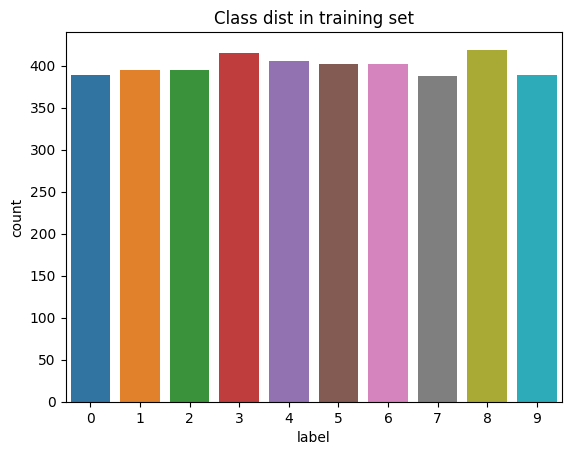

In [ ]:
sns.countplot(x = Y_train)
plt.title('Class dist in training set')
plt.savefig('class_dist_training.png')
plt.show()

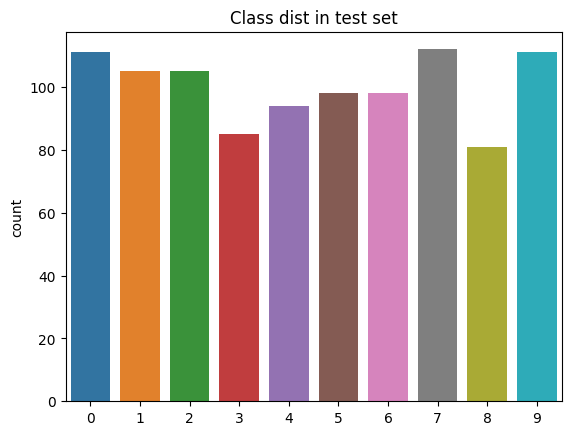

In [ ]:
sns.countplot(x = Y_test)
plt.title('Class dist in test set')
plt.savefig('class_dist_test.png')
plt.show()

##### Dim reduction

In [ ]:
X_embedded_tsne = TSNE(n_components=3, n_iter = 5000 , init='random').fit_transform(X_train)
X_embedded_tsne

NameError: ignored

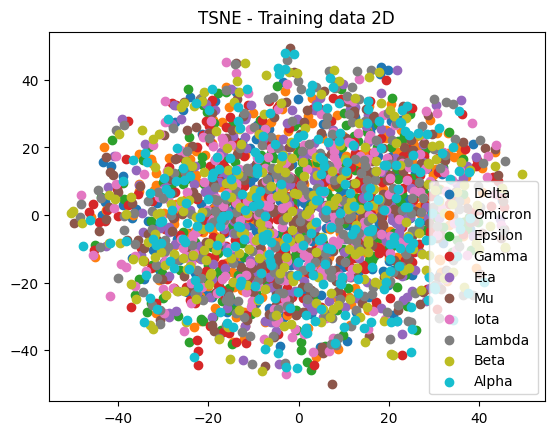

In [ ]:
lower_bound = 0
for k in range(1,11):
    upper_bound= 250*k
    plt.scatter(X_embedded_tsne[lower_bound:upper_bound,0],
                X_embedded_tsne[lower_bound:upper_bound,1])
    lower_bound = upper_bound

plt.title('TSNE - Training data 2D')
plt.legend(labels)
plt.savefig('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/reduction/tsne_train.png')

In [ ]:
X_embedded_pca = PCA(n_components=10).fit_transform(X_train)

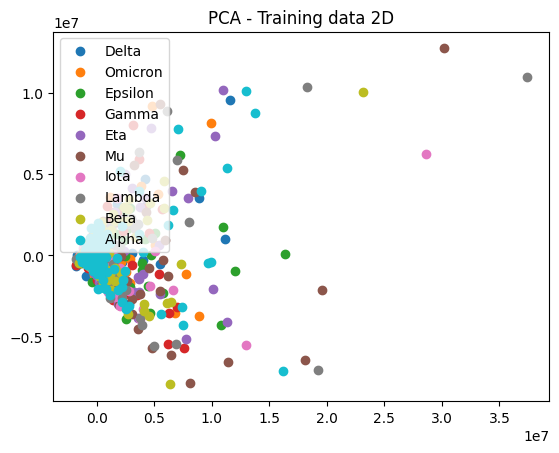

In [ ]:
lower_bound = 0
for k in range(1,11):
    upper_bound= 250*k
    plt.scatter(X_embedded_pca[lower_bound:upper_bound,0],
                X_embedded_pca[lower_bound:upper_bound,1]
                )
    lower_bound = upper_bound

plt.title('PCA - Training data 2D')
plt.legend(labels, loc = 'upper left')
plt.savefig('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/reduction/pca_train.png')

In [ ]:
X_val_embedded_tsne = TSNE(n_components=2, n_iter= 2000, init='random').fit_transform(X_test)

In [ ]:
X_val_embedded_pca = PCA(n_components=2).fit_transform(X_test)

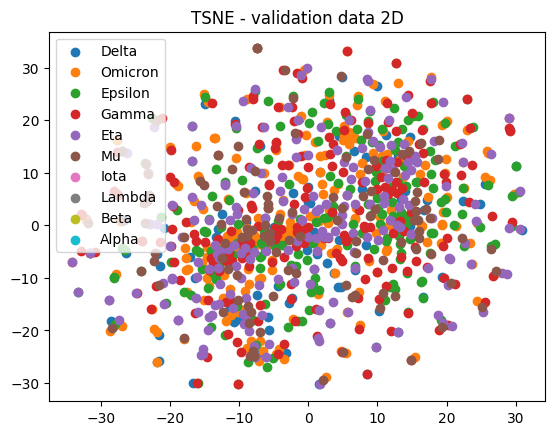

In [ ]:
plt.scatter(X_val_embedded_tsne[:90,0],
                X_val_embedded_tsne[:90,1]
                )

lower_bound = 90
for k in range(1,11):
    upper_bound= 200 + lower_bound
    plt.scatter(X_val_embedded_tsne[lower_bound:upper_bound,0],
                X_val_embedded_tsne[lower_bound:upper_bound,1]
                )
    lower_bound = upper_bound

plt.title('TSNE - validation data 2D')
plt.legend(labels, loc = 'best')
plt.savefig('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/reduction/tsne_val.png')

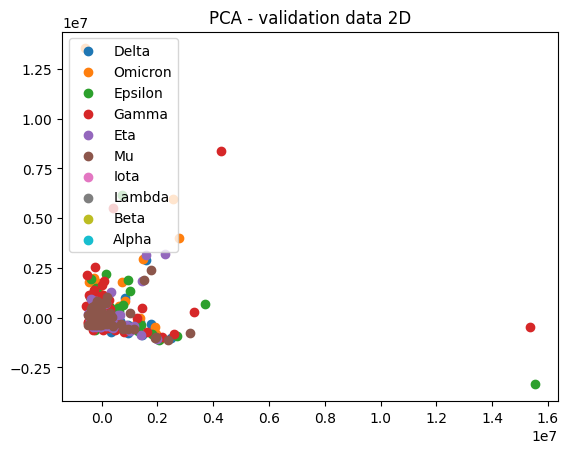

In [ ]:
plt.scatter(X_val_embedded_pca[:90,0],
                X_val_embedded_pca[:90,1]
                )

lower_bound = 90
for k in range(1,11):
    upper_bound= 200 + lower_bound
    plt.scatter(X_val_embedded_pca[lower_bound:upper_bound,0],
                X_val_embedded_pca[lower_bound:upper_bound,1]
                )
    lower_bound = upper_bound

plt.title('PCA - validation data 2D')
plt.legend(labels, loc = 'upper left')
plt.savefig('/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/reduction/pca_val.png')

### Test data preparation

In [19]:
def preprocess_df_test(df_test, maxlen):

    y_test = df_test['label']

    kmer_sequences = df_test['genome'].apply(lambda x: kmer_fun(x, KMER))
    kmer_sequences = tokenizer.texts_to_sequences(kmer_sequences)

    x_test = pad_sequences(kmer_sequences, maxlen = maxlen)
    return np.array(x_test), np.array(y_test)

In [24]:
#MAXLEN = 29941

X_test, Y_test = preprocess_df_test(test_df, MAXLEN)

In [25]:
with open(drive_path + 'Y_test_list_k6.pkl', 'wb') as f:
    pickle.dump(Y_test, f)

In [26]:
with open(drive_path + 'X_test_list_k6.pkl', 'wb') as f:
    pickle.dump(X_test, f)

### Ordinal Encoding

In [ ]:
def nucleotideToDigit(seq):
    digit_seq = []
    seq = list(seq)
    for n in seq:
        if n == 'T' :
            d = -1.5
        elif n =='C' :
            d = 0.5
        elif n == 'A' :
            d = 1.5
        elif n == 'G' :
            d = -0.5
        else:
            d = 0
        digit_seq.append(d)

    return np.array(digit_seq)

nucleotideToDigit('ACTGN')

array([ 1.5,  0.5, -1.5, -0.5,  0. ])

In [ ]:

df_training

,accession_id,lineage,who,label,genome
4227,MW834725,B.1.525,Eta,8,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...
4676,OM898723,C.37,Lambda,9,TCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGG...
800,OM365275,BA.1.1,Omicron,1,AAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAA...
3671,OK064627,B.1.621,Mu,7,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
4193,OU187465,B.1.525,Eta,8,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
...,...,...,...,...,...
4426,MZ358620,B.1.525,Eta,8,ATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGG...
466,MZ715077,AY.3,Delta,0,TCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTG...
3092,OU073304,B.1.351,Beta,6,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
3772,OK233621,B.1.621,Mu,7,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...


In [ ]:
df_training['ORDINAL_SEQ'] = df_training['genome'].apply(lambda x: nucleotideToDigit(x))
df_training

,accession_id,lineage,who,label,genome,ORDINAL_SEQ
4227,MW834725,B.1.525,Eta,8,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...,"[1.5, -0.5, 1.5, -1.5, 0.5, -1.5, -0.5, -1.5, ..."
4676,OM898723,C.37,Lambda,9,TCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGG...,"[-1.5, 0.5, -0.5, -1.5, 0.5, 0.5, -0.5, -1.5, ..."
800,OM365275,BA.1.1,Omicron,1,AAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAA...,"[1.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, ..."
3671,OK064627,B.1.621,Mu,7,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...,"[1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, ..."
4193,OU187465,B.1.525,Eta,8,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...,"[1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, ..."
...,...,...,...,...,...,...
4426,MZ358620,B.1.525,Eta,8,ATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGG...,"[1.5, -1.5, 0.5, -1.5, -0.5, -1.5, -1.5, 0.5, ..."
466,MZ715077,AY.3,Delta,0,TCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTG...,"[-1.5, 0.5, -0.5, 1.5, -1.5, 0.5, -1.5, 0.5, -..."
3092,OU073304,B.1.351,Beta,6,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...,"[1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, ..."
3772,OK233621,B.1.621,Mu,7,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...,"[1.5, -0.5, 1.5, -1.5, 0.5, -1.5, -0.5, -1.5, ..."


In [ ]:
len(df_training.iloc[1]['SEQ']), len(df_training.iloc[1]['ORDINAL_SEQ']), df_training.iloc[1]['PID']

(25665, 25665, 'AH013708 |SARS coronavirus Sin0409| partial sequence')

In [ ]:
print('Average length of the seqeunces: ', int(np.mean(df_training['ORDINAL_SEQ'].str.len())))
maxlen = np.max(df_training['ORDINAL_SEQ'].str.len())
maxlen

Average length of the seqeunces:  29768


29970

In [ ]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(df_training['ORDINAL_SEQ'], maxlen = maxlen)
x_train.shape, type(x_train)

((4000, 29970), numpy.ndarray)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
x_train_smallerdim = pca.fit_transform(x_train)
x_train_smallerdim.shape

(4000, 200)